# Read Data and Create Necessary Columns

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy

from IPython.display import display, HTML

display(HTML("<style>div.output_scroll { height: 25em; }</style>"))
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set(style="whitegrid")

In [2]:
data = pd.read_csv('../data/transactions_ds.csv', sep=';')
del data['price_ttc']

data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.tz_convert('Europe/Paris')

data['year'] = data['date'].dt.year
data['year_week'] = data['date'].dt.isocalendar().week
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.day_name()

data['hour'] = data['date'].dt.hour
data['minute'] = data['date'].dt.minute

data['total_spendings'] = data['quantity'] * data['price_ht']

Remove dublicates. Example:

In [3]:
data[(data['item_id'] == 7) &
     (data['transaction_id'] == 4)]

,item_id,quantity,price_ht,transaction_id,date,year,year_week,month,day,weekday,hour,minute,total_spendings
10,7,1.000,0.000,4,2018-03-08 14:13:29+01:00,2018,10,3,8,Thursday,14,13,0.000
11,7,1.000,0.000,4,2018-03-08 14:13:29+01:00,2018,10,3,8,Thursday,14,13,0.000


In [4]:
data.drop_duplicates(inplace=True)
data.head(3)

,item_id,quantity,price_ht,transaction_id,date,year,year_week,month,day,weekday,hour,minute,total_spendings
0,0,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420
1,1,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420
2,2,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 444103 entries, 0 to 458729
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype                       
---  ------           --------------   -----                       
 0   item_id          444103 non-null  int64                       
 1   quantity         444103 non-null  float64                     
 2   price_ht         444103 non-null  float64                     
 3   transaction_id   444103 non-null  int64                       
 4   date             444103 non-null  datetime64[ns, Europe/Paris]
 5   year             444103 non-null  int64                       
 6   year_week        444103 non-null  UInt32                      
 7   month            444103 non-null  int64                       
 8   day              444103 non-null  int64                       
 9   weekday          444103 non-null  object                      
 10  hour             444103 non-null  int64                       
 11  

# Basic Statistics of the Data

In [5]:
data[['quantity', 'price_ht', 'total_spendings']].describe()

,quantity,price_ht,total_spendings
count,444199.000,444199.000,444199.000
mean,1.350,6.059,12.236
std,23.111,7.733,1793.990
min,0.008,-3.320,-3.320
25%,1.000,2.920,2.940
50%,1.000,4.640,4.920
75%,1.000,7.580,8.910
max,14445.000,1160.190,1183393.800


In [6]:
# check what the observation with max total_spendings
data[data['total_spendings'] == max(data['total_spendings'])]

,item_id,quantity,price_ht,transaction_id,date,year,year_week,month,day,weekday,hour,minute,total_spendings
319383,11,1020.000,1160.190,204385,2021-07-04 11:09:44+02:00,2021,26,7,4,Sunday,11,9,1183393.800


In [7]:
data.head(4)

,item_id,quantity,price_ht,transaction_id,date,year,year_week,month,day,weekday,hour,minute,total_spendings
0,0,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420
1,1,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420
2,2,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420
3,3,1.000,12.420,1,2018-03-08 14:10:59+01:00,2018,10,3,8,Thursday,14,10,12.420


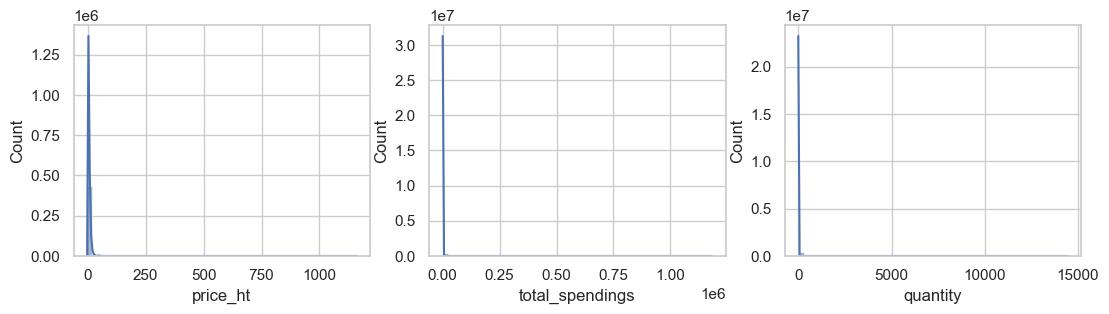

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
sns.histplot(data['price_ht'], kde=True, bins=50, ax=ax[0])
sns.histplot(data['total_spendings'], kde=True, bins=50, ax=ax[1])
sns.histplot(data['quantity'], kde=True, bins=50, ax=ax[2]);

High peaks for all critical variables, which indicates large number of outliers

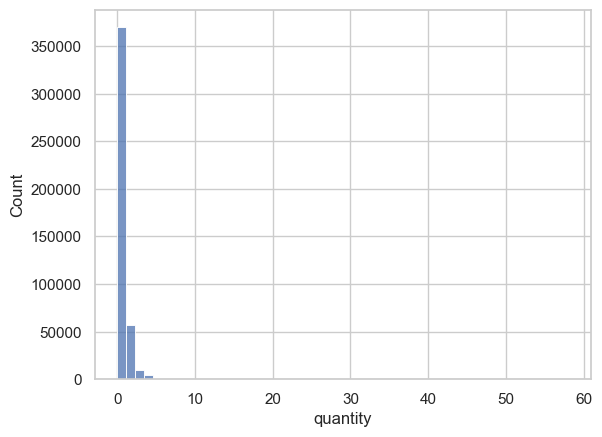

In [9]:
mask = np.abs(scipy.stats.zscore(data[['quantity']])) < 2.5
data = data[mask['quantity']]
sns.histplot(data['quantity'], bins=50);

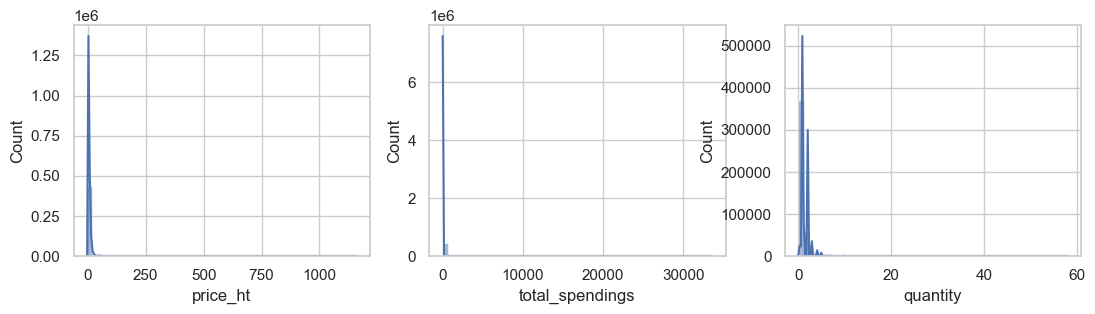

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))
sns.histplot(data['price_ht'], kde=True, bins=50, ax=ax[0])
sns.histplot(data['total_spendings'], kde=True, bins=50, ax=ax[1])
sns.histplot(data['quantity'], kde=True, bins=50, ax=ax[2]);

Now better, but still a lot of products around zero. Why?

In [17]:
data.groupby([pd.cut(data.quantity, [0, 0.25, 0.5, 0.75, 1, 2, 5, 10, 20, 30, 50])]).size()

quantity
(0.0, 0.25]       1798
(0.25, 0.5]       6624
(0.5, 0.75]       4107
(0.75, 1.0]     357068
(1.0, 2.0]       56895
(2.0, 5.0]       16223
(5.0, 10.0]       1146
(10.0, 20.0]       136
(20.0, 30.0]        47
(30.0, 50.0]        47
dtype: int64

**Answer:** a lot of weighted products\
The rest variables also have skewed distribution, but it seems fine, we can scale in for our models with $log$ transformations

### When customers buy  products?

Check if we need to filter data to get rid of 2018 year (COVID) and 2022 (not full information).

#### LF HELP HERE

In [37]:
data_check = data[['transaction_id', 'total_spendings', 'year', 'month']]


=========

In [42]:
data_f = data[(data['year'] != 2020) & 
              (data['year'] != 2022)]

In [45]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data_f.groupby(['weekday'])['total_spendings'].count().reindex(weekdays)

weekday
Monday         833
Tuesday      32780
Wednesday    28474
Thursday     30326
Friday       30784
Saturday     59258
Sunday       93280
Name: total_spendings, dtype: int64

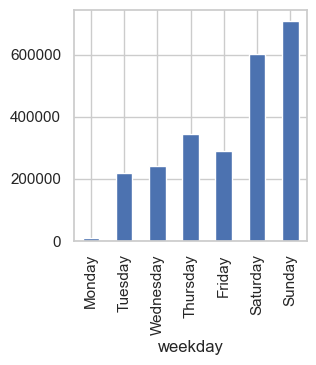

In [43]:
data_f.groupby(['weekday'])['total_spendings'].sum().reindex(weekdays).plot(kind='bar',
                                                                            legend=False,
                                                                            figsize=(3,3));

Seems the bakery is closed on Mondays

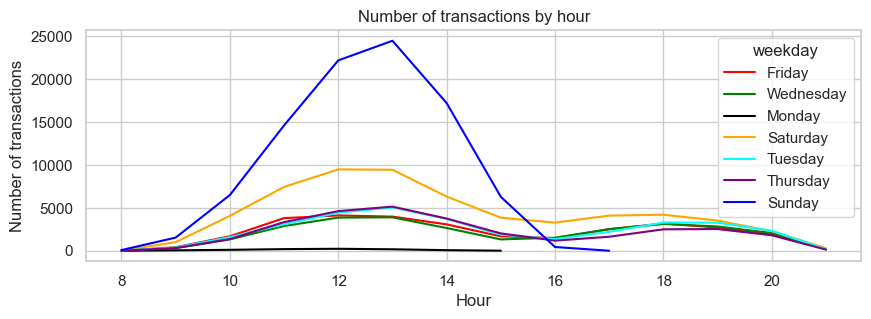

In [54]:
no_trans_by_h = data_f.groupby(['weekday', 'hour'])['transaction_id'].count().reset_index().sort_values(by='hour')

fig, ax = plt.subplots(figsize=(10, 3))
plt_no_trans_by_h = sns.lineplot(no_trans_by_h, 
                                 x='hour', 
                                 y='transaction_id', 
                                 hue='weekday',
                                 palette=['red', 'green', 'black', 'orange', 'cyan', 'purple', 'blue'],
                                 ax=ax)

plt_no_trans_by_h.set(title='Number of transactions by hour',
                      xlabel='Hour',
                      ylabel='Number of transactions');

Again, seems the bakery is closed on Mondays. Peek hours are 12am-2pm. Sunday is the busiest day of a week

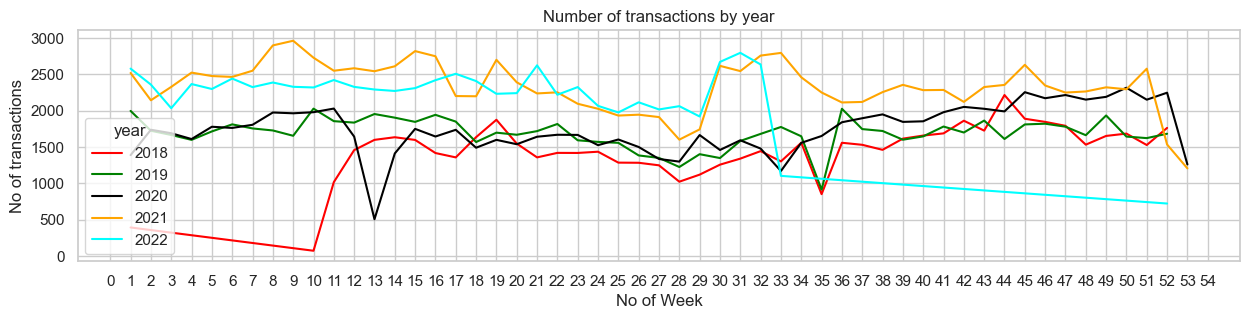

In [104]:
data_yw = data.groupby(['year', 
                        'year_week'])['transaction_id'].count().reset_index().sort_values(by=['year'])

data_yw['year_week'] = data_yw['year_week'].astype('int64')


fig, ax = plt.subplots(figsize=(15, 3))
plot_data_yw = sns.lineplot(data_yw, 
                            x='year_week', 
                            y='transaction_id', 
                            hue='year', 
                            ax=ax,
                            palette=['red', 'green', 'black', 'orange', 'cyan'])
plot_data_yw.set(title='Number of transactions by year',
                 xlabel='No of Week',
                 ylabel='No of transactions')
plot_data_yw.set_xticks(range(55));